In [1]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from datetime import timedelta

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
DATA_DIR = Path('/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs')
HR_CSV = DATA_DIR / "hr_series.csv"
SLEEP_CSV = DATA_DIR / "sleep_series.csv"
LABELS_CSV = DATA_DIR / "nightly_labeled.csv"
PROFILES_CSV = DATA_DIR / "user_profiles.csv"

In [3]:
# Cargar
hr_data = pd.read_csv(HR_CSV, parse_dates=['timestamp'])
sleep_data = pd.read_csv(SLEEP_CSV, parse_dates=['night_date'])
labels = pd.read_csv(LABELS_CSV, parse_dates=['night_date'])

# Normalizar tipos
hr_data['user_id'] = hr_data['user_id'].astype(str)
sleep_data['user_id'] = sleep_data['user_id'].astype(str)
labels['user_id'] = labels['user_id'].astype(str)

# Derivar fecha (día) para HR y contar eventos diarios (tu serie ejemplo es un conteo por día)
hr_data['date'] = hr_data['timestamp'].dt.floor('D')

# Serie diaria de HR (puedes reemplazar "count" por otra métrica; p.ej. mediana HR)
hr_daily = (
    hr_data
    .groupby(['user_id','date'], as_index=False)
    .agg(hr_count=('hr','count'),
         hr_med=('hr','median'))  # opcional, por si luego prefieres mediana
)

# Para el baseline usaremos hr_count como la serie diaria principal

In [4]:
labels.head()

,user_id,night_date,total_hours,deep_minutes,rem_minutes,awake_minutes,sleep_latency_minutes,awakenings,rhr_median,hrv_proxy_median,...,score_S_rem,score_S_awake,score_S_latency,score_C_rhr,score_C_hrv,score_C_resp,recovery_score_0_1,recovery_threshold,recovery_label_binary,failure_minutes
0,1,2024-01-01,6.566667,111,5,107,5,51,NaN,NaN,...,0.0,0.0,1.000,NaN,NaN,NaN,0.330606,0.348959,Deficient Recovery,78
1,1,2024-01-02,5.433333,107,6,80,8,36,NaN,NaN,...,0.0,0.0,0.925,NaN,NaN,NaN,0.289233,0.348959,Deficient Recovery,52
2,1,2024-01-03,6.200000,99,5,130,2,53,NaN,NaN,...,0.0,0.0,1.000,NaN,NaN,NaN,0.305645,0.348959,Deficient Recovery,64
3,1,2024-01-04,7.450000,144,23,108,2,46,NaN,NaN,...,0.0,0.0,1.000,NaN,NaN,NaN,0.378000,0.348959,Adequate Recovery,55
4,1,2024-01-05,5.533333,103,11,83,1,32,NaN,NaN,...,0.0,0.0,1.000,NaN,NaN,NaN,0.301333,0.348959,Deficient Recovery,55


In [5]:
# Mapear etiqueta binaria a 0/1
label_map = {
    'Adequate Recovery': 1,
    'Deficient Recovery': 0
}
labels['target'] = labels['recovery_label_binary'].map(label_map).astype(int)  # ajusta el nombre de la columna real

# Índice maestro de noches etiquetadas
nights = labels[['user_id','night_date','target']].dropna().copy()
nights['night_date'] = pd.to_datetime(nights['night_date'])

In [6]:
# Acceso a archivos y definición de constantes

BASE_DIR = Path('/home/gmartinez/Tesis/Datasets/Synthetic-data')
OUTPUTS_DIR = BASE_DIR / 'outputs'  # subcarpetas: 300, 600, 1200, 1500
COHORTS = ['300', '600', '1200', '1500']
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=SEED):
    import random
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [7]:
class TimeAwareAttention(nn.Module):
    def __init__(self, d_in, d_model, n_heads=4, dropout=0.2):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads
        assert d_model % n_heads == 0
        self.Wq = nn.Linear(d_in, d_model)
        self.Wk = nn.Linear(d_in, d_model)
        self.Wv = nn.Linear(d_in, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.time_decay = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, T, M):
        B, L, Cin = X.shape
        Q = self.Wq(X); K = self.Wk(X); V = self.Wv(X)
        def split(Z): return Z.view(B, L, self.n_heads, self.dk).transpose(1,2)
        Qh, Kh, Vh = split(Q), split(K), split(V)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / (self.dk ** 0.5)
        # Penalización temporal
        Ti = T.unsqueeze(1).unsqueeze(-1); Tj = T.unsqueeze(1).unsqueeze(-2)
        dist = torch.abs(Ti - Tj)
        scores = scores - self.time_decay.abs() * dist
        # Máscara temporal (pasos sin observación en K)
        time_mask = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~time_mask, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        Z = torch.matmul(attn, Vh)
        Z = Z.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.out(Z), attn

class FiLMGenerator(nn.Module):
    def __init__(self, p_dim, d_model, n_layers, hidden=64, dropout=0.1):
        super().__init__()
        self.n_layers = n_layers
        out_dim = n_layers * d_model * 2  # gamma y beta por capa
        self.mlp = nn.Sequential(
            nn.Linear(p_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, p):
        B = p.shape[0]
        out = self.mlp(p).view(B, self.n_layers, 2, -1)  # (B, L, 2, d_model)
        gamma = out[:, :, 0, :]
        beta  = out[:, :, 1, :]
        return gamma, beta

class MTANBackboneFiLM(nn.Module):
    """
    Backbone mTAN que puede ser modulado por FiLM con el perfil (cond).
    Si cond=None, actúa como backbone normal (sin FiLM).
    """
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2, dropout=0.2, p_dim=None, film_hidden=64):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.input_proj = nn.Linear(c_in, d_model)
        self.layers = nn.ModuleList([
            nn.ModuleList([
                TimeAwareAttention(d_model, d_model, n_heads=n_heads, dropout=dropout),
                nn.LayerNorm(d_model),
                nn.Sequential(
                    nn.Linear(d_model, d_model*2),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model*2, d_model)
                ),
                nn.LayerNorm(d_model),
            ]) for _ in range(n_layers)
        ])
        self.use_film = p_dim is not None
        if self.use_film:
            self.film = FiLMGenerator(p_dim=p_dim, d_model=d_model, n_layers=n_layers, hidden=film_hidden, dropout=0.1)

    def forward(self, X, T, M, cond=None):
        x = self.input_proj(X)
        gamma = beta = None
        if self.use_film and cond is not None:
            gamma, beta = self.film(cond)  # (B, n_layers, d_model)
        for li, (attn, ln1, ff, ln2) in enumerate(self.layers):
            h, _ = attn(x, T, M)
            x = ln1(x + h)
            if gamma is not None:
                g = gamma[:, li, :].unsqueeze(1)
                b = beta[:,  li, :].unsqueeze(1)
                x = g * x + b
            f = ff(x)
            x = ln2(x + f)
            if gamma is not None:
                g = gamma[:, li, :].unsqueeze(1)
                b = beta[:,  li, :].unsqueeze(1)
                x = g * x + b
        # Pooling temporal enmascarado
        time_mask = (M.sum(dim=-1) > 0).float()
        masked_x = x * time_mask.unsqueeze(-1)
        denom = time_mask.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled = masked_x.sum(dim=1) / denom
        return pooled

class TSOnlyHead(nn.Module):
    def __init__(self, d_model=128, dropout=0.2):
        super().__init__()
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )
    def forward(self, h): return self.cls(h).squeeze(-1)

class ProfileMLP(nn.Module):
    def __init__(self, p_dim, d_hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(p_dim, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, p): return self.net(p)

class TSPlusProfileHead(nn.Module):
    def __init__(self, d_model=128, p_hidden=64, d_joint=128, dropout=0.2):
        super().__init__()
        self.joint = nn.Sequential(
            nn.Linear(d_model + p_hidden, d_joint),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_joint, 1)
        )
    def forward(self, h_mtan, h_prof):
        return self.joint(torch.cat([h_mtan, h_prof], dim=-1)).squeeze(-1)

class MTANWithFiLMHeads(nn.Module):
    """
    - Fase 1: TS only (backbone sin FiLM).
    - Fase 2: TS + perfil por concatenación post-backbone.
    - Fase 3: TS con FiLM condicionado por perfil (perfil modula el backbone).
    """
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2,
                 p_dim=None, prof_hidden=64, film_hidden=64, dropout=0.2):
        super().__init__()
        # Backbones
        self.backbone_plain = MTANBackboneFiLM(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, p_dim=None)
        self.backbone_film  = MTANBackboneFiLM(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, p_dim=p_dim, film_hidden=film_hidden)
        # Heads
        self.ts_head = TSOnlyHead(d_model=d_model, dropout=dropout)
        self.use_profile = p_dim is not None
        if self.use_profile:
            self.prof_mlp = ProfileMLP(p_dim=p_dim, d_hidden=prof_hidden, dropout=0.1)
            self.ts_p_head = TSPlusProfileHead(d_model=d_model, p_hidden=prof_hidden, d_joint=d_model, dropout=dropout)

    def forward_phase1(self, X, T, M):
        h = self.backbone_plain(X, T, M, cond=None)
        return self.ts_head(h)

    def forward_phase2(self, X, T, M, p):
        h = self.backbone_plain(X, T, M, cond=None)
        h_p = self.prof_mlp(p)
        return self.ts_p_head(h, h_p)

    def forward_phase3(self, X, T, M, p):
        # FiLM: el perfil (sin MLP) condiciona el backbone
        h = self.backbone_film(X, T, M, cond=p)
        return self.ts_head(h)

In [8]:
class TimeDataset(Dataset):
    def __init__(self, X, T, M, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.y[idx]

class TimeDatasetWithProfile(Dataset):
    def __init__(self, X, T, M, P, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.y[idx]

In [9]:
# Utilidades de datos
SLEEP_FEATURES = [
    'total_hours','deep_minutes','rem_minutes','awake_minutes',
    'sleep_latency_minutes','awakenings','failure_minutes'
]

def extract_hr_window(hr_daily_user, night_date, past_days=7, include_night=True, feature='hr_count'):
    L = past_days + (1 if include_night else 0)
    start_date = night_date - timedelta(days=past_days)
    end_date = night_date if include_night else (night_date - timedelta(days=1))
    idx_days = pd.date_range(start=start_date, end=end_date, freq='D')
    ser = (
        pd.DataFrame({'date': idx_days})
        .merge(hr_daily_user[['date', feature]], on='date', how='left')
        [feature].to_numpy(dtype=float)
    )
    if len(ser) != L:
        ser = np.resize(ser, L)
    return ser

def extract_sleep_features_for_night(sleep_user, night_date):
    row = sleep_user.loc[sleep_user['night_date'] == night_date, SLEEP_FEATURES]
    if row.empty:
        return np.array([np.nan]*len(SLEEP_FEATURES), dtype=float)
    return row.iloc[0].astype(float).to_numpy()

def build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'):
    hr_by_user = {u: df.sort_values('date') for u, df in hr_daily.groupby('user_id')}
    sleep_by_user = {u: df.sort_values('night_date') for u, df in sleep_data.groupby('user_id')}
    X_list, T_list, M_list, y_list, meta_list, night_feat_list = [], [], [], [], [], []
    for _, row in nights.iterrows():
        u = row['user_id']; night = row['night_date']; target = row['target']
        hr_user = hr_by_user.get(u, pd.DataFrame(columns=['date',use_hr_feature]))
        sleep_user = sleep_by_user.get(u, pd.DataFrame(columns=['night_date'] + SLEEP_FEATURES))
        hr_vec = extract_hr_window(hr_user, night_date=night, past_days=past_days, include_night=True, feature=use_hr_feature)
        L1 = len(hr_vec)
        t_hr = np.linspace(0.0, 1.0, L1); m_hr = (~np.isnan(hr_vec)).astype(float)
        s_vec = extract_sleep_features_for_night(sleep_user, night)
        t_sl = np.array([1.0]); m_sl = (~np.isnan(s_vec)).astype(float)
        # ensamblar secuencia
        t_seq = np.concatenate([t_hr, t_sl], axis=0)
        C = 1 + len(SLEEP_FEATURES)
        X = np.zeros((L1+1, C), dtype=float)
        M = np.zeros((L1+1, C), dtype=float)
        X[:L1, 0] = hr_vec; M[:L1, 0] = m_hr
        X[L1, 1:] = s_vec;  M[L1, 1:] = m_sl
        X_list.append(X); T_list.append(t_seq); M_list.append(M)
        y_list.append(target); meta_list.append((u, night)); night_feat_list.append(s_vec)
    return X_list, T_list, M_list, np.array(y_list, dtype=int), meta_list, np.vstack(night_feat_list)

def stack_fixed_length(X_list, T_list, M_list):
    return np.stack(X_list, axis=0), np.stack(T_list, axis=0), np.stack(M_list, axis=0)

def standardize_by_train(X_all, M_all, train_idx):
    obs_mask = M_all[train_idx].astype(bool)
    sum_x = np.nansum(np.where(obs_mask, X_all[train_idx], np.nan), axis=(0,1))
    count_x = obs_mask.sum(axis=(0,1)).clip(min=1)
    mean_x = sum_x / count_x
    sum_sq = np.nansum((np.where(obs_mask, X_all[train_idx], mean_x) - mean_x)**2, axis=(0,1))
    var_x = sum_sq / count_x
    std_x = np.sqrt(np.maximum(var_x, 1e-8))
    def apply(X, M):
        Xz = (np.where(M>0, X, mean_x) - mean_x) / std_x
        return np.where(M>0, Xz, 0.0)
    return apply

In [10]:
# Perfiles
CAT_COLS = ['age_group','gender','physical_activity_level','smoking_status','alcohol_consumption','diabetes','hypertension']
NUM_COLS = ['age']

def fit_profile_artifacts(df_train):
    cat_maps = {}
    for c in CAT_COLS:
        cats = list(pd.Series(df_train[c].astype(str)).astype('category').cat.categories)
        if "<UNK>" not in cats: cats += ["<UNK>"]
        cat_maps[c] = cats
    num_stats = {}
    for c in NUM_COLS:
        col = pd.to_numeric(df_train[c], errors='coerce')
        mu = float(col.mean(skipna=True)) if col.notna().any() else 0.0
        sd = float(col.std(skipna=True)) if col.notna().any() else 1.0
        if sd < 1e-8: sd = 1.0
        num_stats[c] = {"mean": mu, "std": sd}
    return cat_maps, num_stats

def one_hot_series(series, categories):
    cat_to_idx = {cat:i for i,cat in enumerate(categories)}
    unk = cat_to_idx.get("<UNK>")
    idx = [cat_to_idx.get(str(v), unk) for v in series.fillna("<UNK>").astype(str)]
    return np.eye(len(categories), dtype=np.float32)[np.array(idx, dtype=int)]

def zscore_series(series, mean, std):
    x = pd.to_numeric(series, errors='coerce').fillna(mean).to_numpy(dtype=np.float32)
    return ((x - mean) / std).astype(np.float32)

def build_profile_matrix(df, cat_maps, num_stats):
    parts = []
    for c in NUM_COLS:
        parts.append(zscore_series(df[c], num_stats[c]['mean'], num_stats[c]['std']).reshape(-1,1))
    for c in CAT_COLS:
        parts.append(one_hot_series(df[c], cat_maps[c]))
    pres = np.ones((df.shape[0],1), dtype=np.float32)
    parts.append(pres)
    P = np.concatenate(parts, axis=1).astype(np.float32)
    return P

In [11]:
# Evaluación y entrenamiento
def evaluate_p1(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, yb in loader:
            prob = torch.sigmoid(model.forward_phase1(Xb.to(device), Tb.to(device), Mb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p2(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase2(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p3_film(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase3(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def train_loop(model, loader, eval_fn, epochs=20, lr=2e-3, wd=1e-4, phase_tag='P'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best = {'auroc': -1, 'state': None}; history = []
    for ep in range(1, epochs+1):
        model.train()
        for batch in loader:
            optimizer.zero_grad()
            if phase_tag == 'P1':
                Xb, Tb, Mb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase1(Xb, Tb, Mb)
            elif phase_tag == 'P2':
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase2(Xb, Tb, Mb, Pb)
            else:  # P3 (FiLM)
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase3(Xb, Tb, Mb, Pb)
            loss = criterion(logit, yb); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()
        auroc, auprc = eval_fn(model)
        history.append({'epoch': ep, 'auroc': auroc, 'auprc': auprc})
        if auroc > best['auroc']:
            best['auroc'] = auroc
            best['state'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"[{phase_tag}] Epoch {ep:02d} | AUROC {auroc:.4f} | AUPRC {auprc:.4f}")
    if best['state'] is not None:
        model.load_state_dict(best['state'])
    return model, history, best['auroc']

In [22]:
# Bucle multi-cohorte
summary_path = OUTPUTS_DIR / "phase_results_summary.json"
# Opcional: descomenta para recomputar desde cero
# if summary_path.exists(): summary_path.unlink()
try:
    summary = json.loads(summary_path.read_text())
except Exception:
    summary = []

all_histories = {}  # para curvas por época por cohorte

for cohort in COHORTS:
    print(f"\n==== Procesando cohorte {cohort} ====")
    data_dir = OUTPUTS_DIR / cohort
    hr_csv = data_dir / "hr_series.csv"
    sleep_csv = data_dir / "sleep_series.csv"
    labels_csv = data_dir / "nightly_labeled.csv"
    profiles_csv = data_dir / "user_profiles.csv"

    # Validación rápida
    for p in [hr_csv, sleep_csv, labels_csv, profiles_csv]:
        if not p.exists():
            print(f"Saltando cohorte {cohort}: falta {p.name}")
            break
    else:
        # Cargar
        hr_data = pd.read_csv(hr_csv, parse_dates=['timestamp'])
        sleep_data = pd.read_csv(sleep_csv, parse_dates=['night_date'])
        labels = pd.read_csv(labels_csv, parse_dates=['night_date'])
        profiles_df = pd.read_csv(profiles_csv)

        for df in (hr_data, sleep_data, labels, profiles_df):
            if 'user_id' in df.columns:
                df['user_id'] = df['user_id'].astype(str)

        # Serie diaria
        hr_data['date'] = hr_data['timestamp'].dt.floor('D')
        hr_daily = (
            hr_data
            .groupby(['user_id','date'], as_index=False)
            .agg(hr_count=('hr','count'),
                 hr_med=('hr','median'))
        )

        # Etiquetas
        label_map = {'Adequate Recovery': 1, 'Deficient Recovery': 0}
        labels['target'] = labels['recovery_label_binary'].map(label_map).astype(int)
        nights = labels[['user_id','night_date','target']].dropna().copy()
        nights['night_date'] = pd.to_datetime(nights['night_date'])

        # Asegurar columnas de sueño
        for col in SLEEP_FEATURES:
            if col not in sleep_data.columns:
                sleep_data[col] = np.nan

        # Construir muestras
        X_list, T_list, M_list, y, meta, night_feats = build_samples(
            hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'
        )
        X_all, T_all, M_all = stack_fixed_length(X_list, T_list, M_list)

        # Split por usuario
        users = np.array([u for u, _ in meta]).astype(str)
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        train_idx, test_idx = next(gss.split(np.zeros(len(users)), groups=users))

        # Estandarizar
        apply_std = standardize_by_train(X_all, M_all, train_idx)
        X_std = apply_std(X_all, M_all)
        X_train, T_train, M_train, y_train = X_std[train_idx], T_all[train_idx], M_all[train_idx], y[train_idx]
        X_test,  T_test,  M_test,  y_test  = X_std[test_idx],  T_all[test_idx],  M_all[test_idx],  y[test_idx]

        # Perfiles
        train_users = sorted(set(users[train_idx]))
        test_users  = sorted(set(users[test_idx]))
        df_prof_train = profiles_df[profiles_df['user_id'].isin(train_users)].copy()
        df_prof_test  = profiles_df[profiles_df['user_id'].isin(test_users)].copy()
        cat_maps, num_stats = fit_profile_artifacts(df_prof_train)
        P_train = build_profile_matrix(df_prof_train, cat_maps, num_stats)
        P_test  = build_profile_matrix(df_prof_test,  cat_maps, num_stats)

        prof_by_user_train = {u: v for u, v in zip(df_prof_train['user_id'].astype(str), list(P_train))}
        prof_by_user_test  = {u: v for u, v in zip(df_prof_test['user_id'].astype(str),  list(P_test))}
        p_dim = P_train.shape[1]

        def build_sample_profiles(meta, train_split_users, prof_train, prof_test, p_dim):
            profiles = []
            for (u, _night) in meta:
                u = str(u)
                vec = prof_train.get(u) if (u in train_split_users) else prof_test.get(u)
                if vec is None:
                    v = np.zeros((p_dim,), dtype=np.float32); v[-1] = 0.0
                    vec = v
                profiles.append(vec.astype(np.float32))
            return np.stack(profiles).astype(np.float32)

        train_split_users_set = set(train_users)
        profiles_all = build_sample_profiles(meta, train_split_users_set, prof_by_user_train, prof_by_user_test, p_dim)
        profiles_train = profiles_all[train_idx]; profiles_test = profiles_all[test_idx]

        # Loaders
        train_loader_p1 = DataLoader(TimeDataset(X_train, T_train, M_train, y_train), batch_size=128, shuffle=True)
        test_loader_p1  = DataLoader(TimeDataset(X_test,  T_test,  M_test,  y_test),  batch_size=256, shuffle=False)

        train_loader_p2 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True)
        test_loader_p2  = DataLoader(TimeDatasetWithProfile(X_test,  T_test,  M_test,  profiles_test,  y_test),  batch_size=256, shuffle=False)

        # Para P3 (FiLM) se usa también TimeDatasetWithProfile (no night features)
        train_loader_p3 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True)
        test_loader_p3  = DataLoader(TimeDatasetWithProfile(X_test,  T_test,  M_test,  profiles_test,  y_test),  batch_size=256, shuffle=False)

        # Modelos y entrenamiento por fase
        EPOCHS = 20
        c_in = X_train.shape[2]

        # Fase 1
        set_seed(SEED)
        model_p1 = MTANWithFiLMHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                                     p_dim=None, dropout=0.2).to(device)
        model_p1, hist_p1, _ = train_loop(model_p1, train_loader_p1,
                                          lambda m: evaluate_p1(m, test_loader_p1),
                                          epochs=EPOCHS, phase_tag='P1')
        auroc_p1, auprc_p1 = evaluate_p1(model_p1, test_loader_p1)

        # Fase 2
        set_seed(SEED)
        model_p2 = MTANWithFiLMHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                                     p_dim=p_dim, dropout=0.2).to(device)
        model_p2, hist_p2, _ = train_loop(model_p2, train_loader_p2,
                                          lambda m: evaluate_p2(m, test_loader_p2),
                                          epochs=EPOCHS, phase_tag='P2')
        auroc_p2, auprc_p2 = evaluate_p2(model_p2, test_loader_p2)

        # Fase 3 (FiLM)
        set_seed(SEED)
        model_p3 = MTANWithFiLMHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                                     p_dim=p_dim, dropout=0.2).to(device)
        model_p3, hist_p3, _ = train_loop(model_p3, train_loader_p3,
                                          lambda m: evaluate_p3_film(m, test_loader_p3),
                                          epochs=EPOCHS, phase_tag='P3')
        auroc_p3, auprc_p3 = evaluate_p3_film(model_p3, test_loader_p3)

        # Guardar resumen acumulado
        item = {
            "cohort_users": int(cohort),
            "phase1": {"auroc": float(auroc_p1), "auprc": float(auprc_p1)},
            "phase2": {"auroc": float(auroc_p2), "auprc": float(auprc_p2)},
            "phase3": {"auroc": float(auroc_p3), "auprc": float(auprc_p3)}  # FiLM
        }
        summary.append(item)
        summary_path.write_text(json.dumps(summary, indent=2))

        # Historias por época (para gráficas por cohorte)
        all_histories[cohort] = {"p1": hist_p1, "p2": hist_p2, "p3": hist_p3}


==== Procesando cohorte 300 ====
[P1] Epoch 01 | AUROC 0.9673 | AUPRC 0.9643
[P1] Epoch 02 | AUROC 0.9693 | AUPRC 0.9675
[P1] Epoch 03 | AUROC 0.9546 | AUPRC 0.9604
[P1] Epoch 04 | AUROC 0.9575 | AUPRC 0.9620
[P1] Epoch 05 | AUROC 0.9627 | AUPRC 0.9652
[P1] Epoch 06 | AUROC 0.9511 | AUPRC 0.9602
[P1] Epoch 07 | AUROC 0.9573 | AUPRC 0.9631
[P1] Epoch 08 | AUROC 0.9559 | AUPRC 0.9624
[P1] Epoch 09 | AUROC 0.9590 | AUPRC 0.9642
[P1] Epoch 10 | AUROC 0.9619 | AUPRC 0.9650
[P1] Epoch 11 | AUROC 0.9633 | AUPRC 0.9657
[P1] Epoch 12 | AUROC 0.9621 | AUPRC 0.9654
[P1] Epoch 13 | AUROC 0.9612 | AUPRC 0.9646
[P1] Epoch 14 | AUROC 0.9597 | AUPRC 0.9643
[P1] Epoch 15 | AUROC 0.9588 | AUPRC 0.9641
[P1] Epoch 16 | AUROC 0.9582 | AUPRC 0.9639
[P1] Epoch 17 | AUROC 0.9585 | AUPRC 0.9640
[P1] Epoch 18 | AUROC 0.9574 | AUPRC 0.9636
[P1] Epoch 19 | AUROC 0.9573 | AUPRC 0.9635
[P1] Epoch 20 | AUROC 0.9572 | AUPRC 0.9634
[P2] Epoch 01 | AUROC 0.9680 | AUPRC 0.9659
[P2] Epoch 02 | AUROC 0.9470 | AUPRC 0.954

In [16]:
summary_path = OUTPUTS_DIR / "phase_results_summary.json"

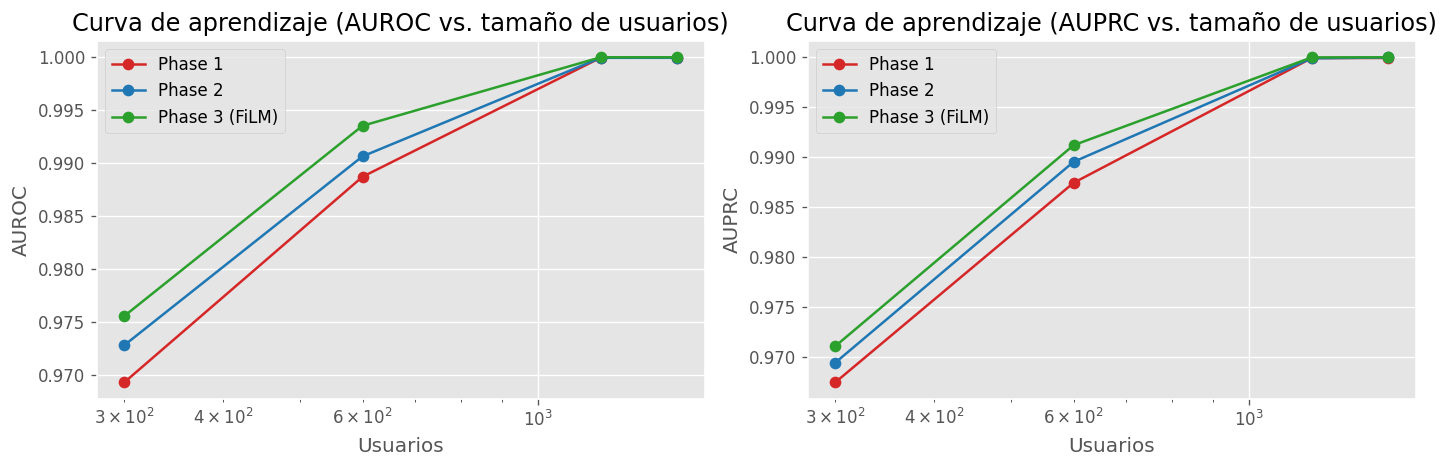

In [18]:
# Visualización: Curvas de aprendizaje multi-cohorte
data = json.loads(summary_path.read_text())
data = sorted(data, key=lambda x: x.get('cohort_users', 0))
sizes = [d.get('cohort_users', np.nan) for d in data]

p1_auroc = [d.get('phase1', {}).get('auroc', np.nan) for d in data]
p2_auroc = [d.get('phase2', {}).get('auroc', np.nan) for d in data]
p3_auroc = [d.get('phase3', {}).get('auroc', np.nan) for d in data]

p1_auprc = [d.get('phase1', {}).get('auprc', np.nan) for d in data]
p2_auprc = [d.get('phase2', {}).get('auprc', np.nan) for d in data]
p3_auprc = [d.get('phase3', {}).get('auprc', np.nan) for d in data]

fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)

# AUROC
ax[0].plot(sizes, p1_auroc, marker='o', label='Phase 1', color='#d62728')
ax[0].plot(sizes, p2_auroc, marker='o', label='Phase 2', color='#1f77b4')
ax[0].plot(sizes, p3_auroc, marker='o', label='Phase 3 (FiLM)', color='#2ca02c')
ax[0].set_title('Curva de aprendizaje (AUROC vs. tamaño de usuarios)')
ax[0].set_xlabel('Usuarios'); ax[0].set_ylabel('AUROC'); ax[0].set_xscale('log'); ax[0].legend()

# AUPRC
ax[1].plot(sizes, p1_auprc, marker='o', label='Phase 1', color='#d62728')
ax[1].plot(sizes, p2_auprc, marker='o', label='Phase 2', color='#1f77b4')
ax[1].plot(sizes, p3_auprc, marker='o', label='Phase 3 (FiLM)', color='#2ca02c')
ax[1].set_title('Curva de aprendizaje (AUPRC vs. tamaño de usuarios)')
ax[1].set_xlabel('Usuarios'); ax[1].set_ylabel('AUPRC'); ax[1].set_xscale('log'); ax[1].legend()

plt.tight_layout(); plt.show()

# Visualización: Curvas por época por cohorte (opcional)
def plot_epoch_curves_for_cohort(hist, cohort_tag):
    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)

    def maybe_plot(key, label, color):
        if key in hist and len(hist[key]) > 0:
            epochs = [h['epoch'] for h in hist[key] if h.get('auroc') is not None]
            aurocs = [h['auroc'] for h in hist[key] if h.get('auroc') is not None]
            auprcs = [h['auprc'] for h in hist[key] if h.get('auprc') is not None]
            if len(epochs) > 0:
                ax[0].plot(epochs, aurocs, label=label, marker='o', color=color, alpha=0.9)
                ax[1].plot(epochs, auprcs, label=label, marker='o', color=color, alpha=0.9)

    maybe_plot('p1', 'P1', '#d62728')
    maybe_plot('p2', 'P2', '#1f77b4')
    maybe_plot('p3', 'P3 (FiLM)', '#2ca02c')

    ax[0].set_title(f'AUROC por época (cohorte {cohort_tag})')
    ax[0].set_xlabel('Época'); ax[0].set_ylabel('AUROC'); ax[0].legend()

    ax[1].set_title(f'AUPRC por época (cohorte {cohort_tag})')
    ax[1].set_xlabel('Época'); ax[1].set_ylabel('AUPRC'); ax[1].legend()

    plt.tight_layout(); plt.show()

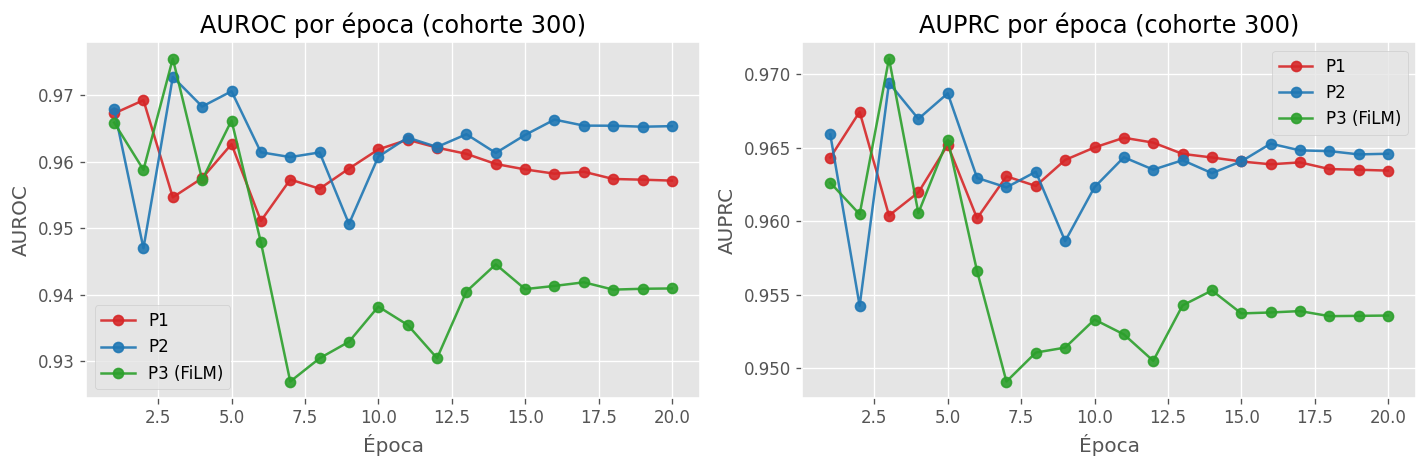

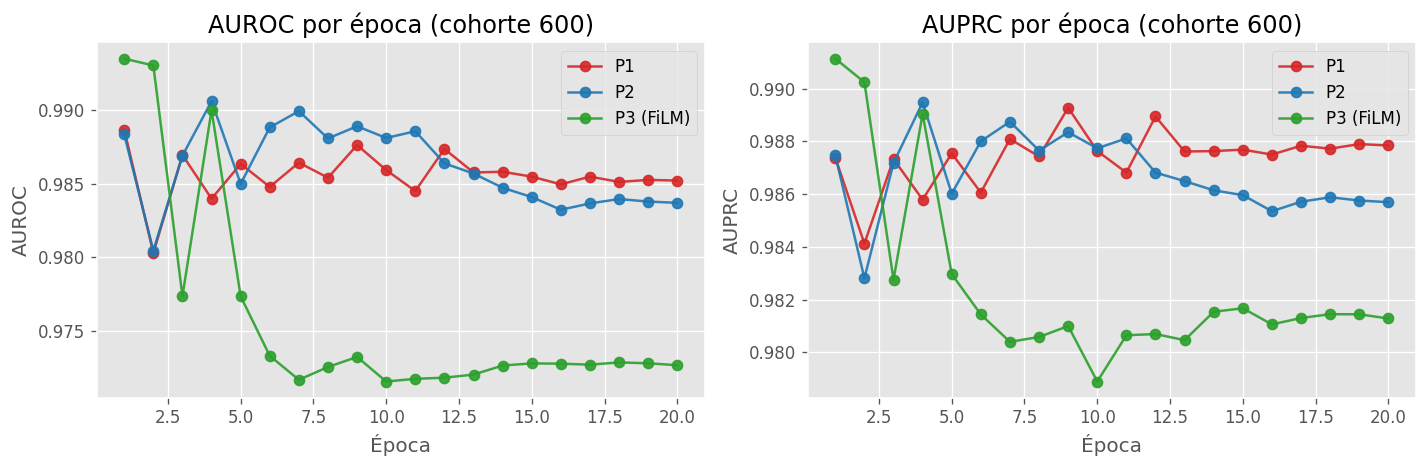

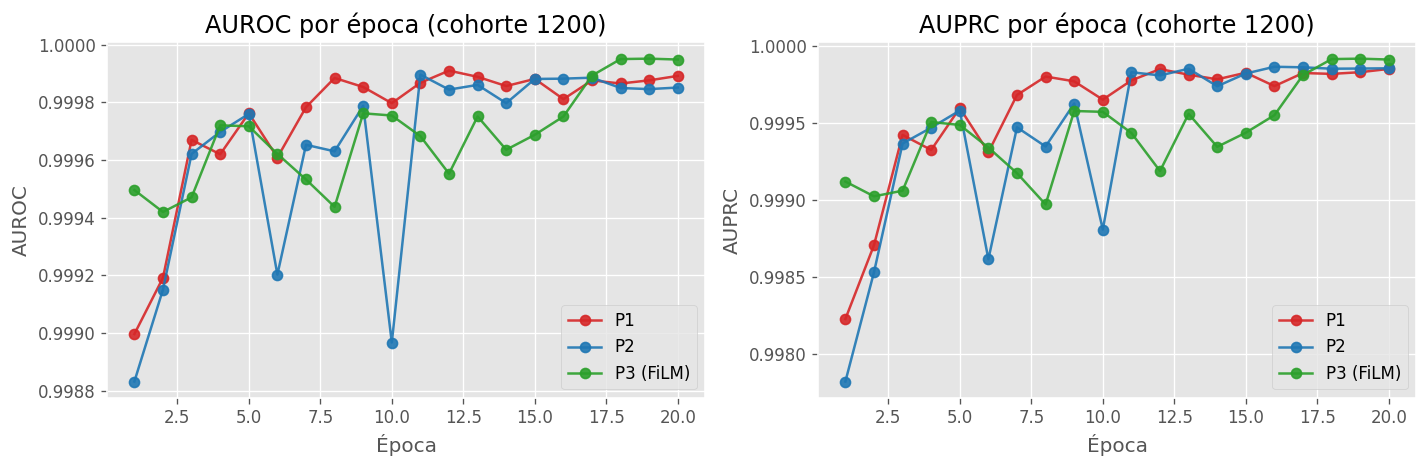

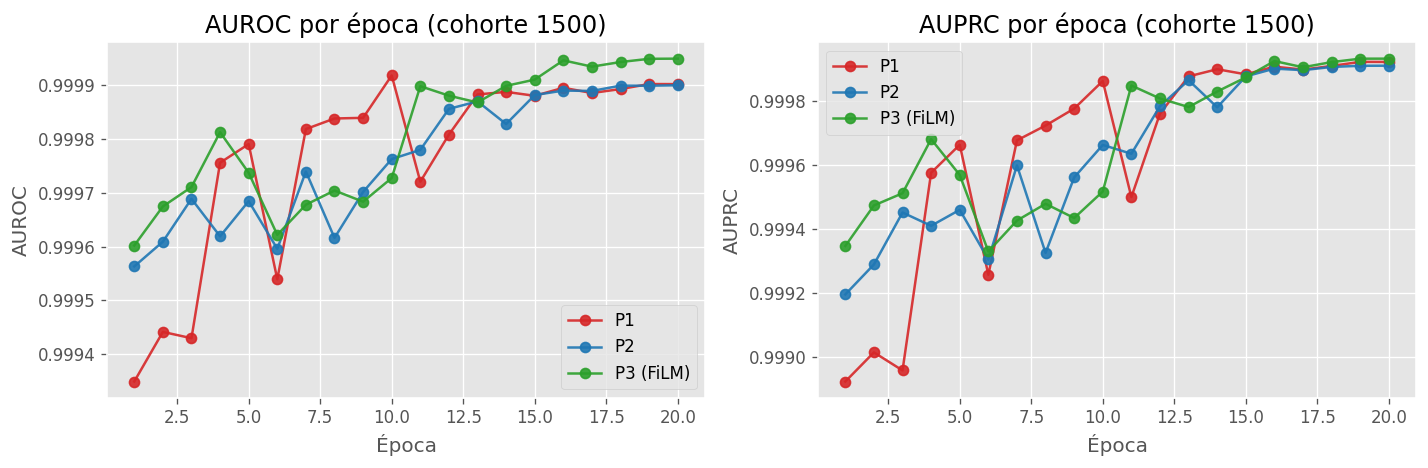

In [23]:
# Graficar por época para cada cohorte:
for cohort, hist in all_histories.items():
    plot_epoch_curves_for_cohort(hist, cohort)

### New sleep sequence

### -------------------------


=== Iniciando pipeline para n=300 usuarios ===
[n=300] Train/Validation instancias: 23198 | Testing instancias: 5543 | Usuarios únicos TV: 240 | Usuarios únicos Test: 60
[n=300] === Fold 1 ===
[n=300] P1 | Epoch 01 | train_loss=0.3912 validation_loss=0.3675 | AUROC train/validation=0.886/0.907 | AUPRC train/validation=0.767/0.831
[n=300] P1 | Epoch 02 | train_loss=0.3769 validation_loss=0.3997 | AUROC train/validation=0.893/0.888 | AUPRC train/validation=0.786/0.775
[n=300] P1 | Epoch 03 | train_loss=0.3653 validation_loss=0.3697 | AUROC train/validation=0.900/0.906 | AUPRC train/validation=0.802/0.832
[n=300] P1 | Epoch 04 | train_loss=0.3396 validation_loss=0.3284 | AUROC train/validation=0.910/0.916 | AUPRC train/validation=0.824/0.848
[n=300] P1 | Epoch 05 | train_loss=0.3372 validation_loss=0.3529 | AUROC train/validation=0.911/0.914 | AUPRC train/validation=0.822/0.838
[n=300] P1 | Epoch 06 | train_loss=0.3342 validation_loss=0.3647 | AUROC train/validation=0.913/0.908 | AUPRC t

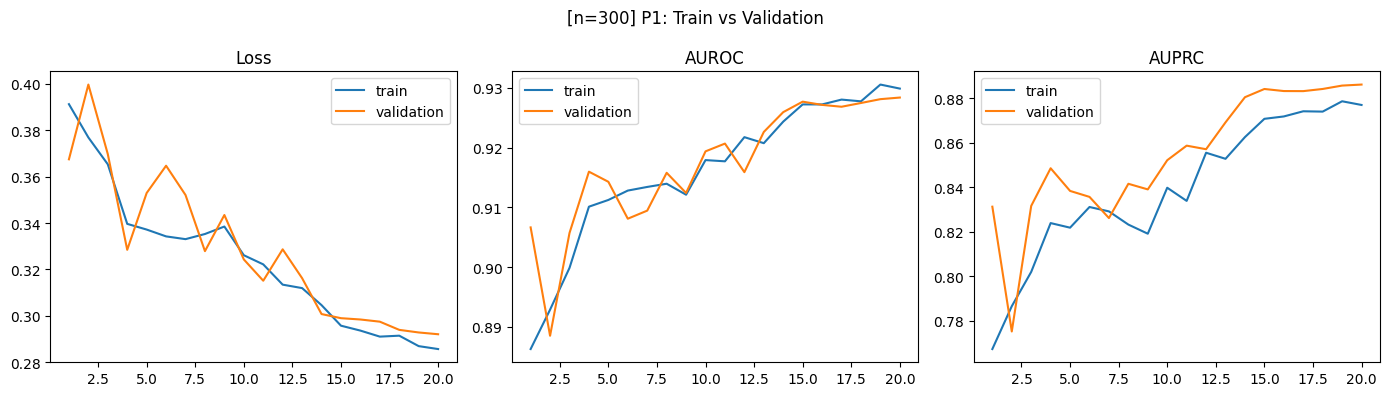

[n=300] P2 | Epoch 01 | train_loss=0.4026 validation_loss=0.3859 | AUROC train/validation=0.878/0.898 | AUPRC train/validation=0.750/0.802
[n=300] P2 | Epoch 02 | train_loss=0.3812 validation_loss=0.4002 | AUROC train/validation=0.889/0.879 | AUPRC train/validation=0.772/0.764
[n=300] P2 | Epoch 03 | train_loss=0.3907 validation_loss=0.3751 | AUROC train/validation=0.885/0.900 | AUPRC train/validation=0.760/0.796
[n=300] P2 | Epoch 04 | train_loss=0.3720 validation_loss=0.3602 | AUROC train/validation=0.897/0.902 | AUPRC train/validation=0.794/0.802
[n=300] P2 | Epoch 05 | train_loss=0.3681 validation_loss=0.3700 | AUROC train/validation=0.898/0.898 | AUPRC train/validation=0.784/0.767
[n=300] P2 | Epoch 06 | train_loss=0.3555 validation_loss=0.3501 | AUROC train/validation=0.903/0.907 | AUPRC train/validation=0.794/0.813
[n=300] P2 | Epoch 07 | train_loss=0.3421 validation_loss=0.3426 | AUROC train/validation=0.910/0.915 | AUPRC train/validation=0.820/0.839
[n=300] P2 | Epoch 08 | tra

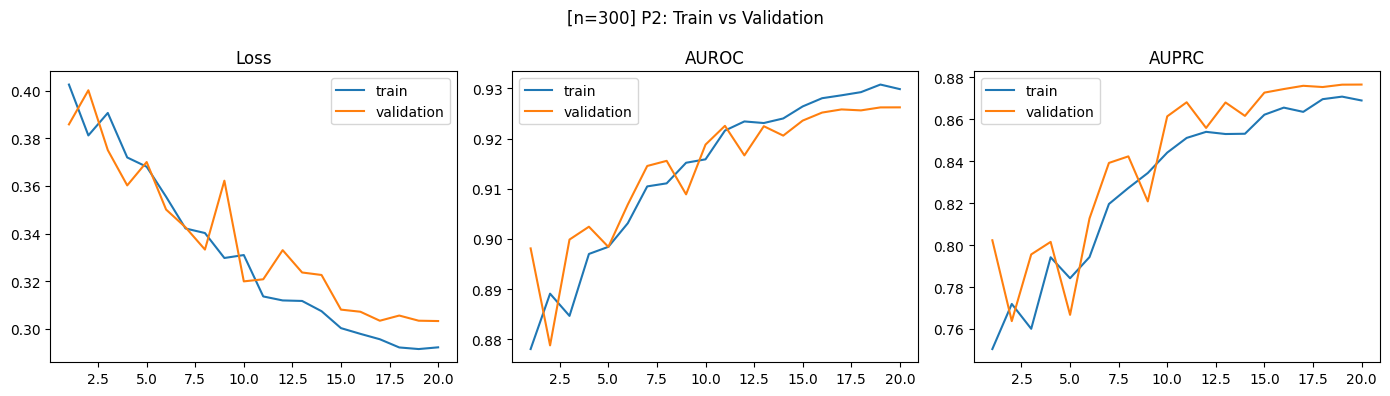

[n=300] P3 | Epoch 01 | train_loss=0.4132 validation_loss=0.4054 | AUROC train/validation=0.871/0.886 | AUPRC train/validation=0.717/0.764
[n=300] P3 | Epoch 02 | train_loss=0.3799 validation_loss=0.3776 | AUROC train/validation=0.890/0.898 | AUPRC train/validation=0.764/0.791
[n=300] P3 | Epoch 03 | train_loss=0.3728 validation_loss=0.3646 | AUROC train/validation=0.896/0.903 | AUPRC train/validation=0.779/0.818
[n=300] P3 | Epoch 04 | train_loss=0.3579 validation_loss=0.3513 | AUROC train/validation=0.904/0.909 | AUPRC train/validation=0.797/0.812
[n=300] P3 | Epoch 05 | train_loss=0.3447 validation_loss=0.3598 | AUROC train/validation=0.910/0.911 | AUPRC train/validation=0.807/0.828
[n=300] P3 | Epoch 06 | train_loss=0.3364 validation_loss=0.3395 | AUROC train/validation=0.913/0.913 | AUPRC train/validation=0.813/0.815
[n=300] P3 | Epoch 07 | train_loss=0.3302 validation_loss=0.3571 | AUROC train/validation=0.917/0.912 | AUPRC train/validation=0.824/0.830
[n=300] P3 | Epoch 08 | tra

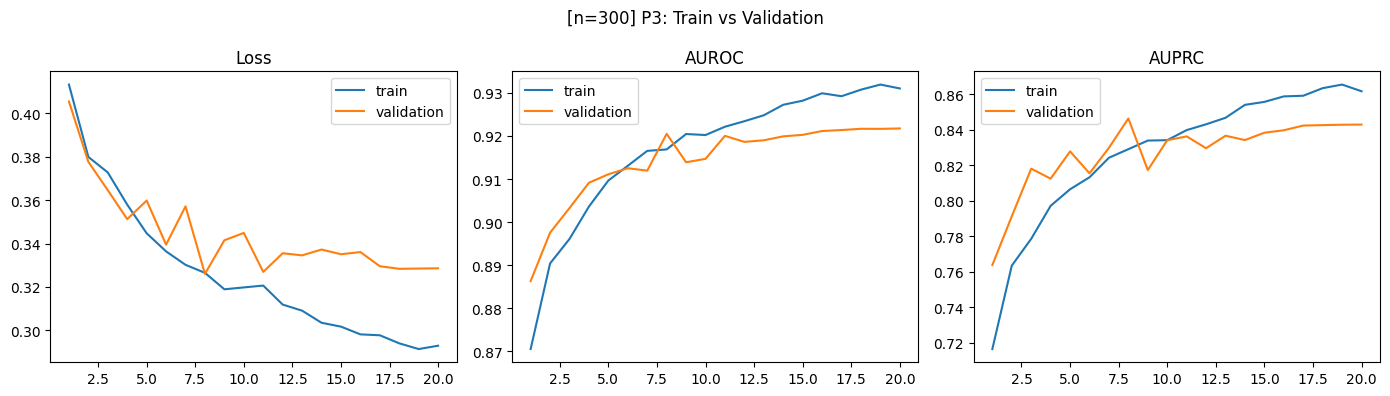

[n=300] Fold 1 | Testing AUROC P1/P2/P3 = 0.899 / 0.905 / 0.903 | AUPRC P1/P2/P3 = 0.854 / 0.847 / 0.824
[n=300] === Fold 2 ===
[n=300] P1 | Epoch 01 | train_loss=0.3892 validation_loss=0.3701 | AUROC train/validation=0.889/0.910 | AUPRC train/validation=0.785/0.841
[n=300] P1 | Epoch 02 | train_loss=0.3709 validation_loss=0.3665 | AUROC train/validation=0.898/0.911 | AUPRC train/validation=0.812/0.840
[n=300] P1 | Epoch 03 | train_loss=0.3445 validation_loss=0.3210 | AUROC train/validation=0.909/0.923 | AUPRC train/validation=0.835/0.869
[n=300] P1 | Epoch 04 | train_loss=0.3613 validation_loss=0.3409 | AUROC train/validation=0.902/0.916 | AUPRC train/validation=0.808/0.844
[n=300] P1 | Epoch 05 | train_loss=0.3623 validation_loss=0.3477 | AUROC train/validation=0.899/0.909 | AUPRC train/validation=0.798/0.820
[n=300] P1 | Epoch 06 | train_loss=0.3469 validation_loss=0.3398 | AUROC train/validation=0.907/0.917 | AUPRC train/validation=0.815/0.841
[n=300] P1 | Epoch 07 | train_loss=0.3

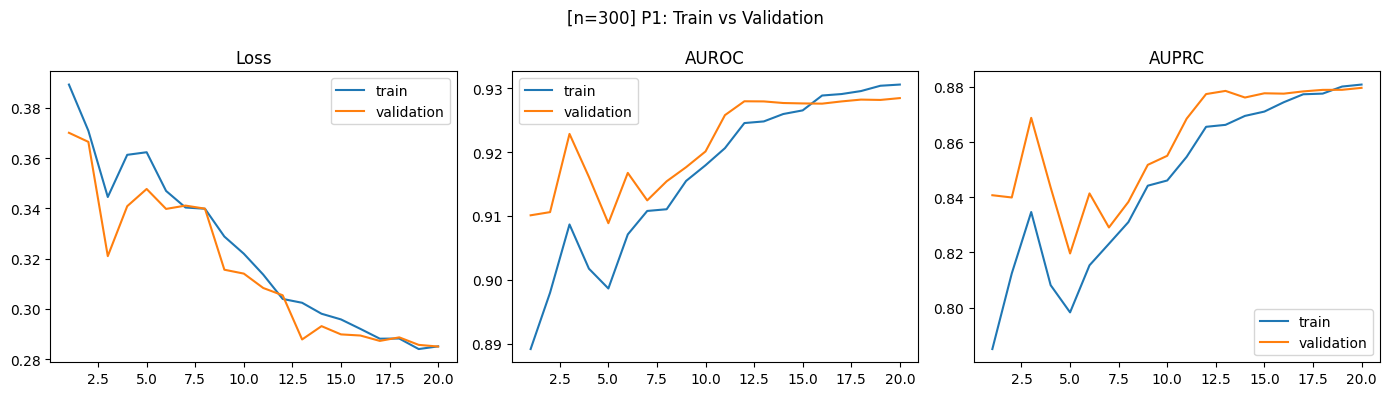

[n=300] P2 | Epoch 01 | train_loss=0.3962 validation_loss=0.3499 | AUROC train/validation=0.884/0.906 | AUPRC train/validation=0.771/0.799
[n=300] P2 | Epoch 02 | train_loss=0.3747 validation_loss=0.3585 | AUROC train/validation=0.896/0.901 | AUPRC train/validation=0.796/0.811
[n=300] P2 | Epoch 03 | train_loss=0.3588 validation_loss=0.3914 | AUROC train/validation=0.904/0.896 | AUPRC train/validation=0.812/0.804
[n=300] P2 | Epoch 04 | train_loss=0.3593 validation_loss=0.3454 | AUROC train/validation=0.903/0.911 | AUPRC train/validation=0.808/0.817
[n=300] P2 | Epoch 05 | train_loss=0.3411 validation_loss=0.3612 | AUROC train/validation=0.910/0.910 | AUPRC train/validation=0.822/0.831
[n=300] P2 | Epoch 06 | train_loss=0.3318 validation_loss=0.3613 | AUROC train/validation=0.915/0.916 | AUPRC train/validation=0.836/0.837
[n=300] P2 | Epoch 07 | train_loss=0.3319 validation_loss=0.3330 | AUROC train/validation=0.916/0.919 | AUPRC train/validation=0.841/0.844
[n=300] P2 | Epoch 08 | tra

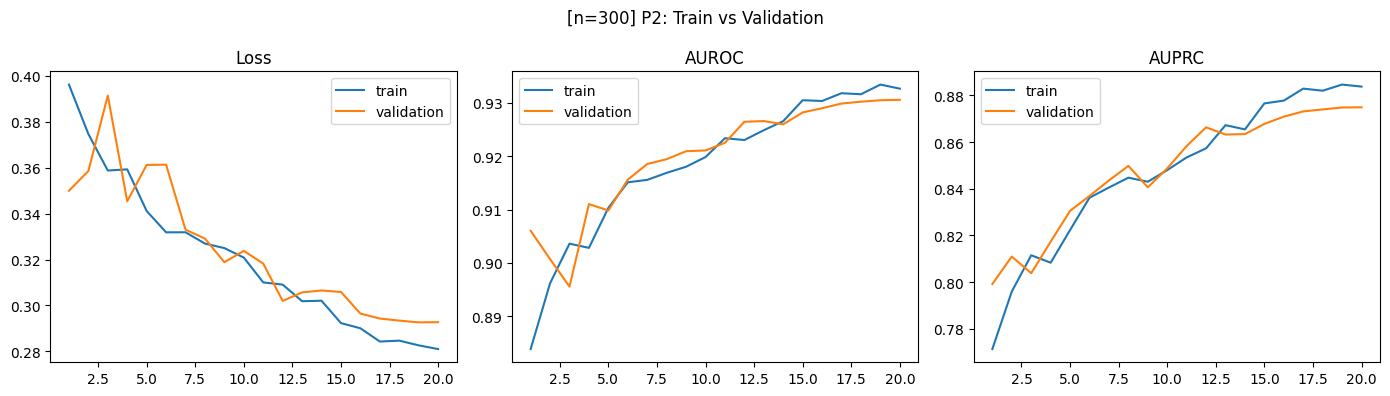

[n=300] P3 | Epoch 01 | train_loss=0.4080 validation_loss=0.3765 | AUROC train/validation=0.875/0.895 | AUPRC train/validation=0.744/0.775
[n=300] P3 | Epoch 02 | train_loss=0.3780 validation_loss=0.3649 | AUROC train/validation=0.891/0.901 | AUPRC train/validation=0.769/0.786
[n=300] P3 | Epoch 03 | train_loss=0.3714 validation_loss=0.3664 | AUROC train/validation=0.897/0.904 | AUPRC train/validation=0.783/0.792
[n=300] P3 | Epoch 04 | train_loss=0.3602 validation_loss=0.3557 | AUROC train/validation=0.902/0.905 | AUPRC train/validation=0.797/0.791
[n=300] P3 | Epoch 05 | train_loss=0.3507 validation_loss=0.3427 | AUROC train/validation=0.906/0.910 | AUPRC train/validation=0.804/0.808
[n=300] P3 | Epoch 06 | train_loss=0.3509 validation_loss=0.3420 | AUROC train/validation=0.907/0.909 | AUPRC train/validation=0.809/0.803
[n=300] P3 | Epoch 07 | train_loss=0.3376 validation_loss=0.3266 | AUROC train/validation=0.913/0.918 | AUPRC train/validation=0.820/0.830
[n=300] P3 | Epoch 08 | tra

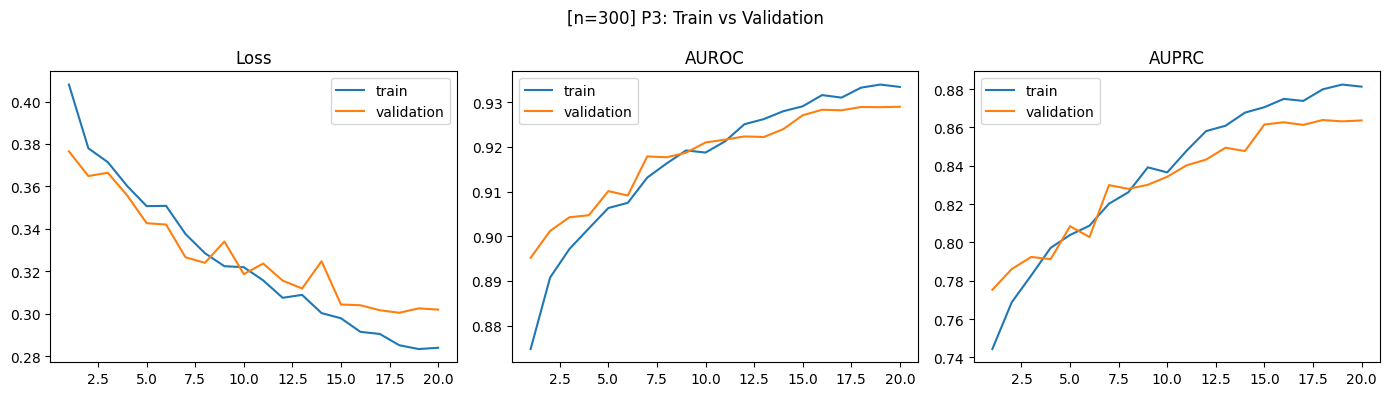

[n=300] Fold 2 | Testing AUROC P1/P2/P3 = 0.901 / 0.913 / 0.906 | AUPRC P1/P2/P3 = 0.856 / 0.861 / 0.847
[n=300] === Fold 3 ===
[n=300] P1 | Epoch 01 | train_loss=0.3871 validation_loss=0.3519 | AUROC train/validation=0.892/0.911 | AUPRC train/validation=0.795/0.837
[n=300] P1 | Epoch 02 | train_loss=0.3684 validation_loss=0.3447 | AUROC train/validation=0.900/0.909 | AUPRC train/validation=0.810/0.837
[n=300] P1 | Epoch 03 | train_loss=0.3671 validation_loss=0.3752 | AUROC train/validation=0.900/0.896 | AUPRC train/validation=0.805/0.766
[n=300] P1 | Epoch 04 | train_loss=0.3787 validation_loss=0.3636 | AUROC train/validation=0.894/0.902 | AUPRC train/validation=0.792/0.792
[n=300] P1 | Epoch 05 | train_loss=0.3638 validation_loss=0.3579 | AUROC train/validation=0.900/0.904 | AUPRC train/validation=0.798/0.811
[n=300] P1 | Epoch 06 | train_loss=0.3547 validation_loss=0.3822 | AUROC train/validation=0.906/0.905 | AUPRC train/validation=0.817/0.807
[n=300] P1 | Epoch 07 | train_loss=0.3

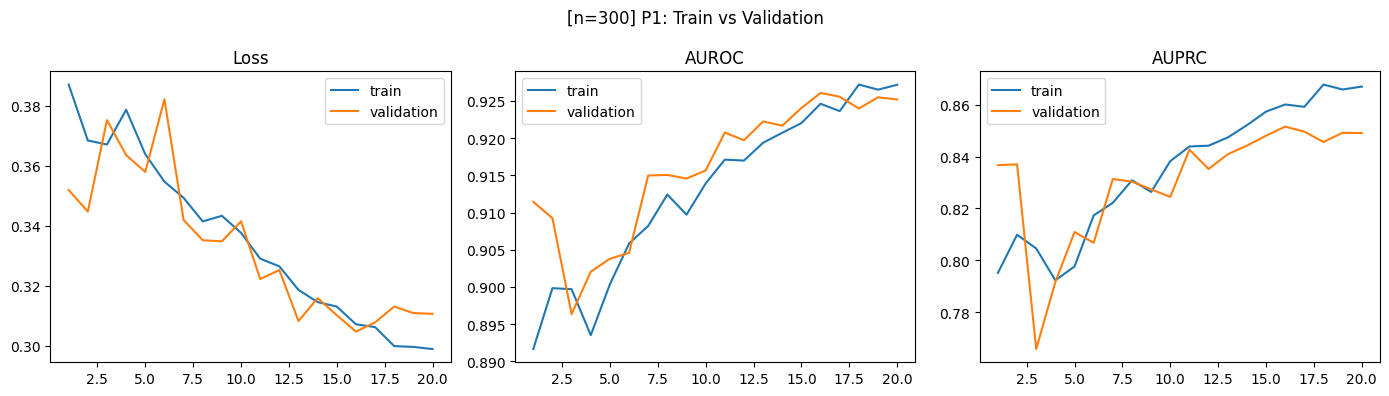

[n=300] P2 | Epoch 01 | train_loss=0.4002 validation_loss=0.4064 | AUROC train/validation=0.881/0.880 | AUPRC train/validation=0.758/0.751
[n=300] P2 | Epoch 02 | train_loss=0.3923 validation_loss=0.3740 | AUROC train/validation=0.886/0.896 | AUPRC train/validation=0.765/0.778
[n=300] P2 | Epoch 03 | train_loss=0.3678 validation_loss=0.3520 | AUROC train/validation=0.898/0.908 | AUPRC train/validation=0.788/0.796
[n=300] P2 | Epoch 04 | train_loss=0.3650 validation_loss=0.3551 | AUROC train/validation=0.901/0.904 | AUPRC train/validation=0.787/0.802
[n=300] P2 | Epoch 05 | train_loss=0.3800 validation_loss=0.3741 | AUROC train/validation=0.895/0.906 | AUPRC train/validation=0.786/0.788
[n=300] P2 | Epoch 06 | train_loss=0.3588 validation_loss=0.3423 | AUROC train/validation=0.904/0.911 | AUPRC train/validation=0.799/0.810
[n=300] P2 | Epoch 07 | train_loss=0.3551 validation_loss=0.3398 | AUROC train/validation=0.905/0.915 | AUPRC train/validation=0.806/0.815
[n=300] P2 | Epoch 08 | tra

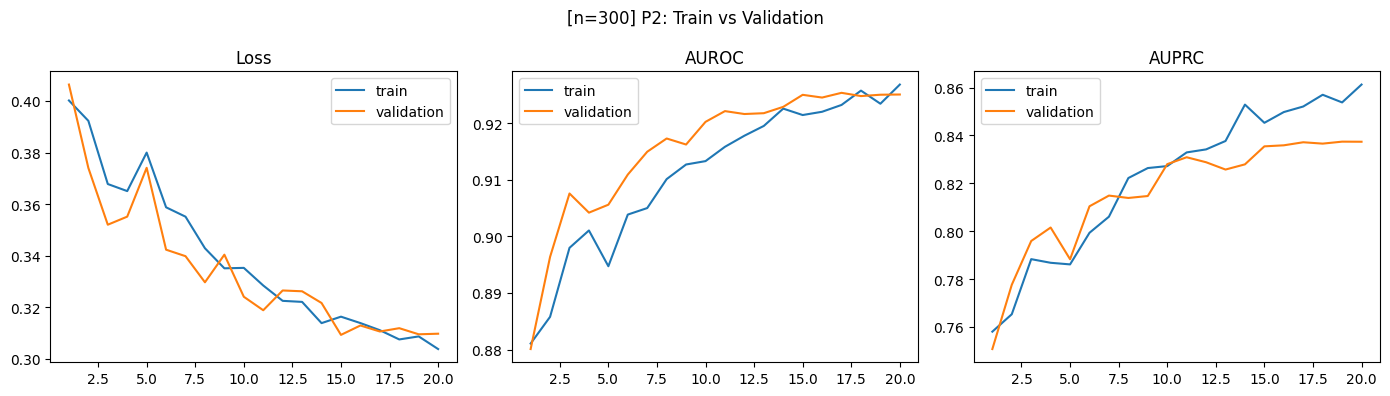

[n=300] P3 | Epoch 01 | train_loss=0.4049 validation_loss=0.3808 | AUROC train/validation=0.878/0.894 | AUPRC train/validation=0.754/0.760
[n=300] P3 | Epoch 02 | train_loss=0.3718 validation_loss=0.3492 | AUROC train/validation=0.894/0.906 | AUPRC train/validation=0.777/0.793
[n=300] P3 | Epoch 03 | train_loss=0.3646 validation_loss=0.3649 | AUROC train/validation=0.900/0.903 | AUPRC train/validation=0.792/0.795
[n=300] P3 | Epoch 04 | train_loss=0.3611 validation_loss=0.3557 | AUROC train/validation=0.903/0.907 | AUPRC train/validation=0.794/0.791
[n=300] P3 | Epoch 05 | train_loss=0.3690 validation_loss=0.3511 | AUROC train/validation=0.898/0.906 | AUPRC train/validation=0.782/0.797
[n=300] P3 | Epoch 06 | train_loss=0.3582 validation_loss=0.3507 | AUROC train/validation=0.904/0.903 | AUPRC train/validation=0.802/0.780
[n=300] P3 | Epoch 07 | train_loss=0.3529 validation_loss=0.3525 | AUROC train/validation=0.907/0.900 | AUPRC train/validation=0.805/0.757
[n=300] P3 | Epoch 08 | tra

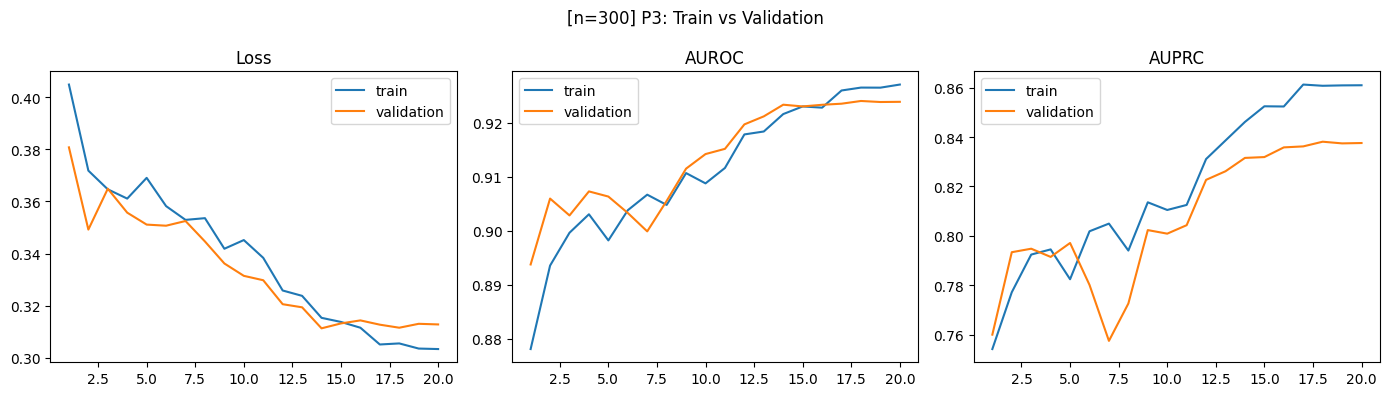

[n=300] Fold 3 | Testing AUROC P1/P2/P3 = 0.897 / 0.900 / 0.901 | AUPRC P1/P2/P3 = 0.836 / 0.816 / 0.822

[n=300] === Resultados por fold (validation) ===
   fold  P1_AUROC  P1_AUPRC  P2_AUROC  P2_AUPRC  P3_AUROC  P3_AUPRC
0     1     0.928     0.886     0.926     0.877     0.922     0.843
1     2     0.928     0.880     0.931     0.875     0.929     0.864
2     3     0.925     0.849     0.925     0.837     0.924     0.838

[n=300] Promedios (validation):
fold        2.000
P1_AUROC    0.927
P1_AUPRC    0.872
P2_AUROC    0.927
P2_AUPRC    0.863
P3_AUROC    0.925
P3_AUPRC    0.848
dtype: float64


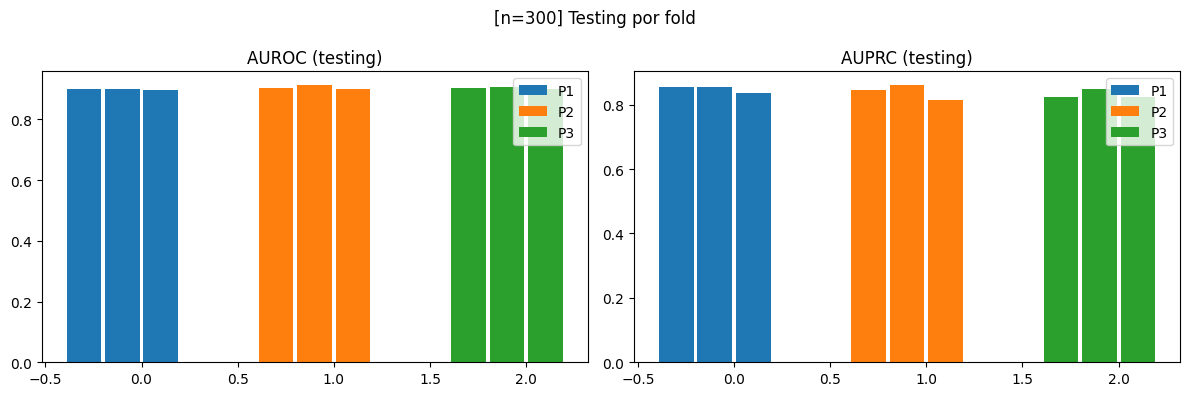


=== Iniciando pipeline para n=600 usuarios ===


KeyboardInterrupt: 

In [2]:
# -*- coding: utf-8 -*-
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

# ======================
# Raíz de datos y tamaños
# ======================
DATA_ROOT = Path('/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs')
SIZES = [300, 600, 1200, 1500]

# ======================
# Hiperparámetros
# ======================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

PAST_DAYS = 7
PAST_NIGHTS = 3
L_MAX = PAST_DAYS + PAST_NIGHTS + 1  # 11
SLEEP_FEATURES = [
    'total_hours','deep_minutes','rem_minutes','awake_minutes',
    'sleep_latency_minutes','awakenings','failure_minutes'
]
USE_HR_MED = False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

D_MODEL = 128
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.2
LR = 2e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
GRAD_CLIP = 1.0
BATCH_TRAIN = 64
BATCH_VAL = 128
BATCH_TEST = 128

# ======================
# Utilidades de datos
# ======================
def load_data_from_dir(data_dir: Path):
    hr_csv = data_dir / "hr_series.csv"
    sleep_csv = data_dir / "sleep_series.csv"
    labels_csv = data_dir / "nightly_labeled.csv"
    profiles_csv = data_dir / "user_profiles.csv"

    hr_df = pd.read_csv(hr_csv, parse_dates=['timestamp'])
    sleep_df = pd.read_csv(sleep_csv, parse_dates=['night_date'])
    labels_df = pd.read_csv(labels_csv, parse_dates=['night_date'])
    profiles_df = pd.read_csv(profiles_csv)

    for df in (hr_df, sleep_df, labels_df, profiles_df):
        if 'user_id' in df.columns:
            df['user_id'] = df['user_id'].astype(str)
    return hr_df, sleep_df, labels_df, profiles_df

def get_hr_by_user_daily(hr_data):
    hr_data = hr_data.copy()
    hr_data['date'] = hr_data['timestamp'].dt.floor('D')
    if USE_HR_MED:
        out = (
            hr_data.groupby(['user_id','date'], as_index=False)
            .agg(hr_count=('hr','count'), hr_med=('hr','median'))
            .sort_values(['user_id','date'])
        )
    else:
        out = (
            hr_data.groupby(['user_id','date'], as_index=False)
            .agg(hr_count=('hr','count'))
            .sort_values(['user_id','date'])
        )
    return out

def ensure_sleep_columns(sleep_df):
    sleep_df = sleep_df.copy()
    for col in SLEEP_FEATURES:
        if col not in sleep_df.columns:
            sleep_df[col] = np.nan
    return sleep_df

def map_labels_to_binary(labels_df):
    df = labels_df.copy()
    if 'recovery_label_binary' in df.columns:
        col = df['recovery_label_binary']
        if col.dtype == 'object':
            mapping = {
                'Adequate Recovery': 1,
                'Deficient Recovery': 0,
                'adequate': 1,
                'deficient': 0,
                'Adequate': 1,
                'Deficient': 0,
                'Positive': 1,
                'Negative': 0
            }
            df['target'] = col.map(mapping)
            if df['target'].isna().any():
                df['target'] = df['recovery_label_binary'].astype(str).str.lower().map(
                    lambda x: 1 if ('adequate' in x or 'positive' in x or x in ('1','true','yes')) else
                              (0 if ('deficient' in x or 'negative' in x or x in ('0','false','no')) else np.nan)
                )
        else:
            df['target'] = col.astype(int)
    elif 'target' in df.columns:
        col = df['target']
        if col.dtype == 'object':
            df['target'] = pd.to_numeric(col, errors='coerce')
        df['target'] = df['target'].astype(float).round().astype(int)
    elif 'label' in df.columns:
        col = df['label']
        if col.dtype == 'object':
            df['target'] = col.astype(str).str.lower().map(
                lambda x: 1 if ('adequate' in x or 'positive' in x or x in ('1','true','yes')) else
                          (0 if ('deficient' in x or 'negative' in x or x in ('0','false','no')) else np.nan)
            )
        else:
            df['target'] = col.astype(int)
    else:
        raise ValueError("LABELS_CSV debe contener 'recovery_label_binary', 'target' o 'label'.")

    if df['target'].isna().any():
        raise ValueError(f"Hay {int(df['target'].isna().sum())} etiquetas sin mapear en 'target'.")
    return df

def fetch_hr_day(hr_daily_user, day_ts: pd.Timestamp):
    day = pd.Timestamp(pd.Timestamp(day_ts).normalize())
    row = hr_daily_user.loc[hr_daily_user['date'] == day]
    if row.empty:
        return (np.nan, np.nan) if USE_HR_MED else np.nan
    if USE_HR_MED:
        return float(row['hr_count'].iloc[0]), float(row['hr_med'].iloc[0])
    return float(row['hr_count'].iloc[0])

def fetch_sleep_night(sleep_user, night_ts: pd.Timestamp):
    night = pd.Timestamp(pd.Timestamp(night_ts).normalize())
    row = sleep_user.loc[sleep_user['night_date'] == night, SLEEP_FEATURES]
    if row.empty:
        return np.array([np.nan]*len(SLEEP_FEATURES), dtype=float)
    return row.iloc[0].astype(float).to_numpy()

def build_samples_interleaved(hr_daily, sleep_data, nights_df, past_days=7, past_nights=3):
    hr_by_user = {u: df.sort_values('date') for u, df in hr_daily.groupby('user_id')}
    sleep_by_user = {u: df.sort_values('night_date') for u, df in sleep_data.groupby('user_id')}
    X_list, T_list, M_list, y_list, meta_list = [], [], [], [], []
    for _, row in nights_df.iterrows():
        u = str(row['user_id'])
        night0 = pd.to_datetime(row['night_date'])
        target = int(row['target'])
        hr_user = hr_by_user.get(u, pd.DataFrame(columns=['date','hr_count'] + (['hr_med'] if USE_HR_MED else [])))
        sleep_user = sleep_by_user.get(u, pd.DataFrame(columns=['night_date'] + SLEEP_FEATURES))
        base = pd.Timestamp(night0.normalize())
        day_dates = [base - pd.Timedelta(days=d) for d in range(past_days, 0, -1)]
        night_dates = [base - pd.Timedelta(days=d) for d in range(past_nights, 0, -1)] + [base]
        steps = [('day', d) for d in day_dates] + [('night', n) for n in night_dates]
        L = len(steps)
        hr_channels = 2 if USE_HR_MED else 1
        C = hr_channels + len(SLEEP_FEATURES)
        X = np.zeros((L, C), dtype=float)
        M = np.zeros((L, C), dtype=float)
        T = np.linspace(0.0, 1.0, L)
        for i, (typ, dt) in enumerate(steps):
            if typ == 'day':
                v = fetch_hr_day(hr_user, dt)
                if USE_HR_MED:
                    v_count, v_med = v
                    X[i, 0] = 0.0 if np.isnan(v_count) else v_count
                    M[i, 0] = 0.0 if np.isnan(v_count) else 1.0
                    X[i, 1] = 0.0 if np.isnan(v_med) else v_med
                    M[i, 1] = 0.0 if np.isnan(v_med) else 1.0
                else:
                    X[i, 0] = 0.0 if np.isnan(v) else v
                    M[i, 0] = 0.0 if np.isnan(v) else 1.0
        start = hr_channels
        for i, (typ, dt) in enumerate(steps):
            if typ == 'night':
                sv = fetch_sleep_night(sleep_user, dt)
                X[i, start:] = np.where(np.isnan(sv), 0.0, sv)
                M[i, start:] = (~np.isnan(sv)).astype(float)
                for c in range(hr_channels):
                    X[i, c] = 0.0; M[i, c] = 0.0
        X_list.append(X); T_list.append(T); M_list.append(M); y_list.append(target); meta_list.append((u, base))
    return X_list, T_list, M_list, np.array(y_list, dtype=int), meta_list

def pad_to_max_length(seq, max_len, fill_X=0.0, fill_M=0.0, fill_T=None):
    X, T, M = seq
    L, C = X.shape
    Xp = np.full((max_len, C), fill_X, dtype=float)
    Mp = np.full((max_len, C), fill_M, dtype=float)
    Tp = np.linspace(0.0, 1.0, max_len) if fill_T is None else np.full((max_len,), fill_T, dtype=float)
    Xp[:L] = X; Mp[:L] = M; Tp[:L] = T
    return Xp, Tp, Mp

def stack_and_pad(X_list, T_list, M_list, L_max):
    Xp, Tp, Mp = [], [], []
    for X, T, M in zip(X_list, T_list, M_list):
        Xpi, Tpi, Mpi = pad_to_max_length((X, T, M), L_max)
        Xp.append(Xpi); Tp.append(Tpi); Mp.append(Mpi)
    return np.stack(Xp, axis=0), np.stack(Tp, axis=0), np.stack(Mp, axis=0)

# ======================
# Estandarización por canal
# ======================
def compute_channel_stats(X_train, M_train):
    B, L, C = X_train.shape
    means = np.zeros((C,), dtype=float)
    stds = np.ones((C,), dtype=float)
    for c in range(C):
        mask_c = M_train[..., c].astype(bool)
        vals = X_train[..., c][mask_c]
        if vals.size == 0:
            means[c] = 0.0; stds[c] = 1.0
        else:
            means[c] = float(np.mean(vals))
            stds[c] = float(np.std(vals) + 1e-6)
    return means, stds

def standardize_by_stats(X, M, means, stds):
    X_std = (X - means[None, None, :]) / stds[None, None, :]
    X_std = np.where(M == 1.0, X_std, 0.0)
    return X_std

# ======================
# Datasets
# ======================
class TimeDataset(Dataset):
    def __init__(self, X, T, M, y, user_ids=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.user_ids = user_ids if user_ids is not None else [None]*len(y)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.M[idx], self.y[idx], self.user_ids[idx]

class TimeDatasetWithProfile(TimeDataset):
    def __init__(self, X, T, M, y, profiles, user_ids=None):
        super().__init__(X, T, M, y, user_ids)
        self.P = torch.tensor(profiles, dtype=torch.float32)
    def __getitem__(self, idx):
        X, T, M, y, uid = super().__getitem__(idx)
        return X, T, M, y, uid, self.P[idx]

# ======================
# mTAN-like + FiLM (modelos)
# ======================
class TimeAttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.2):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.time_decay = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))

    def forward(self, x, T, M, gamma=None, beta=None):
        B, L, d = x.size()
        Q = self.Wq(x); K = self.Wk(x); V = self.Wv(x)
        def split_heads(t): return t.view(B, L, self.n_heads, self.dk).transpose(1, 2)
        Qh, Kh, Vh = split_heads(Q), split_heads(K), split_heads(V)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / np.sqrt(self.dk)
        Ti = T.unsqueeze(1).unsqueeze(-1)
        Tj = T.unsqueeze(1).unsqueeze(-2)
        time_dist = torch.abs(Ti - Tj)
        scores = scores - self.time_decay * time_dist
        step_valid = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~step_valid, float('-inf'))
        A = torch.softmax(scores, dim=-1)
        A = self.dropout(A)
        Zh = torch.matmul(A, Vh)
        Z = Zh.transpose(1, 2).contiguous().view(B, L, d)
        h_attn = self.out(Z)
        y1 = self.ln1(x + h_attn)
        if gamma is not None and beta is not None:
            y1 = y1 * gamma + beta
        f = self.ffn(y1)
        y2 = self.ln2(y1 + f)
        if gamma is not None and beta is not None:
            y2 = y2 * gamma + beta
        return y2

class MTANBackbone(nn.Module):
    def __init__(self, in_channels, d_model=128, n_layers=2, n_heads=4, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(in_channels, d_model)
        self.layers = nn.ModuleList([
            TimeAttentionBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.d_model = d_model
        self.n_layers = n_layers
    def forward(self, X, T, M, gammas=None, betas=None):
        h = self.input_proj(X)
        for l, layer in enumerate(self.layers):
            gamma_l = None if gammas is None else gammas[:, l, :].unsqueeze(1)
            beta_l  = None if betas  is None else betas[:, l, :].unsqueeze(1)
            h = layer(h, T, M, gamma=gamma_l, beta=beta_l)
        return h

class FiLMGenerator(nn.Module):
    def __init__(self, p_dim, d_model, n_layers, hidden=64, dropout=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(p_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2*n_layers*d_model)
        )
        nn.init.zeros_(self.mlp[-1].weight)
        nn.init.zeros_(self.mlp[-1].bias)
        self.d_model = d_model
        self.n_layers = n_layers
    def forward(self, P):
        B = P.size(0)
        out = self.mlp(P).view(B, 2, self.n_layers, self.d_model)
        gammas = out[:, 0, :, :] + 1.0
        betas  = out[:, 1, :, :]
        return gammas, betas

class HeadMLP(nn.Module):
    def __init__(self, d_in, d_hidden=64, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, 1)
        )
    def forward(self, x): return self.net(x).squeeze(-1)

# Modelos por fase
class ModelPhase1_TS(nn.Module):
    def __init__(self, in_channels, d_model=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS, dropout=DROPOUT):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.head = HeadMLP(d_model, d_hidden=64, dropout=dropout)
    def forward(self, X, T, M):
        h = self.backbone(X, T, M, gammas=None, betas=None)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        return self.head(h_seq)

class ModelPhase2_TSProfile(nn.Module):
    def __init__(self, in_channels, p_dim, d_model=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS, dropout=DROPOUT):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.profile_mlp = nn.Sequential(
            nn.Linear(p_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.head = HeadMLP(d_model + 64, d_hidden=64, dropout=dropout)
    def forward(self, X, T, M, P):
        h = self.backbone(X, T, M, gammas=None, betas=None)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        h_prof = self.profile_mlp(P)
        return self.head(torch.cat([h_seq, h_prof], dim=-1))

class ModelPhase3_FiLM(nn.Module):
    def __init__(self, in_channels, p_dim, d_model=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS, dropout=DROPOUT, film_hidden=64):
        super().__init__()
        self.backbone = MTANBackbone(in_channels, d_model, n_layers, n_heads, dropout)
        self.film = FiLMGenerator(p_dim, d_model, n_layers, hidden=film_hidden, dropout=0.1)
        self.head = HeadMLP(d_model, d_hidden=64, dropout=dropout)
    def forward(self, X, T, M, P):
        gammas, betas = self.film(P)
        h = self.backbone(X, T, M, gammas=gammas, betas=betas)
        step_valid = (M.sum(dim=-1) > 0).float()
        denom = torch.clamp(step_valid.sum(dim=1, keepdim=True), min=1.0)
        h_seq = (h * step_valid.unsqueeze(-1)).sum(dim=1) / denom
        return self.head(h_seq)

# ======================
# Entrenamiento y evaluación
# ======================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    logits_all, targets_all = [], []
    for batch in loader:
        optimizer.zero_grad()
        if len(batch) == 5:
            X, T, M, y, _ = batch
            X, T, M, y = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE)
            logits = model(X, T, M)
        else:
            X, T, M, y, _, P = batch
            X, T, M, y, P = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE), P.to(DEVICE)
            logits = model(X, T, M, P)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        logits_all.append(logits.detach().cpu().numpy())
        targets_all.append(y.detach().cpu().numpy())
    yhat = np.concatenate(logits_all); yt = np.concatenate(targets_all)
    try: auroc = roc_auc_score(yt, yhat)
    except Exception: auroc = np.nan
    try: auprc = average_precision_score(yt, yhat)
    except Exception: auprc = np.nan
    return total_loss / len(yt), auroc, auprc

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    logits_all, targets_all = [], []
    for batch in loader:
        if len(batch) == 5:
            X, T, M, y, _ = batch
            X, T, M, y = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE)
            logits = model(X, T, M)
        else:
            X, T, M, y, _, P = batch
            X, T, M, y, P = X.to(DEVICE), T.to(DEVICE), M.to(DEVICE), y.to(DEVICE), P.to(DEVICE)
            logits = model(X, T, M, P)
        loss = criterion(logits, y)
        total_loss += loss.item() * X.size(0)
        logits_all.append(logits.detach().cpu().numpy())
        targets_all.append(y.detach().cpu().numpy())
    yhat = np.concatenate(logits_all); yt = np.concatenate(targets_all)
    try: auroc = roc_auc_score(yt, yhat)
    except Exception: auroc = np.nan
    try: auprc = average_precision_score(yt, yhat)
    except Exception: auprc = np.nan
    return total_loss / len(yt), auroc, auprc

def run_phase(phase_name, train_loader, val_loader, in_channels, p_dim=None, label_prefix=""):
    if phase_name == 'P1':
        model = ModelPhase1_TS(in_channels).to(DEVICE)
    elif phase_name == 'P2':
        assert p_dim is not None
        model = ModelPhase2_TSProfile(in_channels, p_dim).to(DEVICE)
    elif phase_name == 'P3':
        assert p_dim is not None
        model = ModelPhase3_FiLM(in_channels, p_dim).to(DEVICE)
    else:
        raise ValueError("phase_name must be P1, P2 or P3")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    criterion = nn.BCEWithLogitsLoss()

    history = {'train_auroc': [], 'train_auprc': [], 'val_auroc': [], 'val_auprc': [], 'train_loss': [], 'val_loss': []}
    best_val = -np.inf
    best_state = None

    for ep in range(1, EPOCHS+1):
        tl, tr_auc, tr_pr = train_one_epoch(model, train_loader, optimizer, criterion)
        vl, va_auc, va_pr = eval_one_epoch(model, val_loader, criterion)
        scheduler.step()

        history['train_loss'].append(tl); history['val_loss'].append(vl)
        history['train_auroc'].append(tr_auc); history['val_auroc'].append(va_auc)
        history['train_auprc'].append(tr_pr); history['val_auprc'].append(va_pr)

        score = np.nanmean([va_auc, va_pr])
        if score > best_val:
            best_val = score
            best_state = { 'model': model.state_dict() }

        print(f"{label_prefix} {phase_name} | Epoch {ep:02d} | train_loss={tl:.4f} validation_loss={vl:.4f} | "
              f"AUROC train/validation={tr_auc:.3f}/{va_auc:.3f} | AUPRC train/validation={tr_pr:.3f}/{va_pr:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state['model'])
    return model, history

def plot_history(history, title):
    epochs = range(1, len(history['train_loss'])+1)
    fig, axs = plt.subplots(1, 3, figsize=(14,4))
    axs[0].plot(epochs, history['train_loss'], label='train')
    axs[0].plot(epochs, history['val_loss'], label='validation')
    axs[0].set_title('Loss'); axs[0].legend()
    axs[1].plot(epochs, history['train_auroc'], label='train')
    axs[1].plot(epochs, history['val_auroc'], label='validation')
    axs[1].set_title('AUROC'); axs[1].legend()
    axs[2].plot(epochs, history['train_auprc'], label='train')
    axs[2].plot(epochs, history['val_auprc'], label='validation')
    axs[2].set_title('AUPRC'); axs[2].legend()
    fig.suptitle(title)
    plt.tight_layout()
    return fig

def plot_testing_bars(test_metrics, title):
    phases = ['P1','P2','P3']
    n_folds = max(len(test_metrics[p]) for p in phases)
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    # AUROC
    for i, p in enumerate(phases):
        aurocs = [m[0] for m in test_metrics[p]]
        axs[0].bar([i + (j- n_folds/2)*0.2 for j in range(len(aurocs))], aurocs, width=0.18, label=p)
    axs[0].set_title('AUROC (testing)')
    axs[0].legend()
    # AUPRC
    for i, p in enumerate(phases):
        auprcs = [m[1] for m in test_metrics[p]]
        axs[1].bar([i + (j- n_folds/2)*0.2 for j in range(len(auprcs))], auprcs, width=0.18, label=p)
    axs[1].set_title('AUPRC (testing)')
    axs[1].legend()
    fig.suptitle(title)
    plt.tight_layout()
    return fig

# ======================
# Pipeline por tamaño (con test holdout)
# ======================
def run_for_size(size: int):
    data_dir = DATA_ROOT / str(size)
    print(f"\n=== Iniciando pipeline para n={size} usuarios ===")

    hr_df, sleep_df, labels_df, profiles_df = load_data_from_dir(data_dir)
    sleep_df = ensure_sleep_columns(sleep_df)
    labels_df = map_labels_to_binary(labels_df)

    nights = labels_df[['user_id','night_date','target']].dropna().copy()
    nights['night_date'] = pd.to_datetime(nights['night_date'])
    hr_daily = get_hr_by_user_daily(hr_df)

    X_list, T_list, M_list, y, meta = build_samples_interleaved(
        hr_daily, sleep_df, nights, past_days=PAST_DAYS, past_nights=PAST_NIGHTS
    )
    user_ids = [u for (u, _) in meta]
    X_all, T_all, M_all = stack_and_pad(X_list, T_list, M_list, L_MAX)

    profiles_df = profiles_df.copy()
    profiles_df['user_id'] = profiles_df['user_id'].astype(str)
    P_cols = [c for c in profiles_df.columns if c != 'user_id']
    P_mat = profiles_df.set_index('user_id')[P_cols]
    P_mat = P_mat.apply(lambda col: col.fillna(col.mean()) if col.dtype != 'object' else col)
    for c in list(P_mat.columns):
        if P_mat[c].dtype == 'object':
            dummies = pd.get_dummies(P_mat[c], prefix=c)
            P_mat = pd.concat([P_mat.drop(columns=[c]), dummies], axis=1)
    P_mat = P_mat.reindex(user_ids).fillna(P_mat.mean())
    P_vals = P_mat.to_numpy().astype(np.float32)
    P_vals = (P_vals - np.nanmean(P_vals, axis=0)) / (np.nanstd(P_vals, axis=0) + 1e-6)
    p_dim = P_vals.shape[1]
    in_channels = X_all.shape[-1]

    # Holdout testing (20% usuarios)
    groups_by_instance = np.array(user_ids)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    trainval_idx, test_idx = next(gss.split(X_all, y, groups=groups_by_instance))

    if len(test_idx) == 0:
        raise RuntimeError(f"[n={size}] Conjunto de testing vacío. Verifica distribución de usuarios.")

    users_tv = [user_ids[i] for i in trainval_idx]
    users_te = [user_ids[i] for i in test_idx]
    print(f"[n={size}] Train/Validation instancias: {len(trainval_idx)} | Testing instancias: {len(test_idx)} | "
          f"Usuarios únicos TV: {len(set(users_tv))} | Usuarios únicos Test: {len(set(users_te))}")

    X_tv, T_tv, M_tv, y_tv = X_all[trainval_idx], T_all[trainval_idx], M_all[trainval_idx], y[trainval_idx]
    X_te, T_te, M_te, y_te = X_all[test_idx], T_all[test_idx], M_all[test_idx], y[test_idx]
    P_tv, P_te = P_vals[trainval_idx], P_vals[test_idx]

    gkf = GroupKFold(n_splits=3)
    results_val = []
    test_metrics = {'P1': [], 'P2': [], 'P3': []}
    size_label = f"[n={size}]"

    fold_counter = 0
    for tr_idx_rel, va_idx_rel in gkf.split(X_tv, y_tv, groups=np.array(users_tv)):
        fold_counter += 1
        print(f"{size_label} === Fold {fold_counter} ===")

        X_tr, T_tr, M_tr, y_tr = X_tv[tr_idx_rel], T_tv[tr_idx_rel], M_tv[tr_idx_rel], y_tv[tr_idx_rel]
        X_va, T_va, M_va, y_va = X_tv[va_idx_rel], T_tv[va_idx_rel], M_tv[va_idx_rel], y_tv[va_idx_rel]
        P_tr, P_va = P_tv[tr_idx_rel], P_tv[va_idx_rel]
        u_tr = [users_tv[i] for i in tr_idx_rel]
        u_va = [users_tv[i] for i in va_idx_rel]

        means, stds = compute_channel_stats(X_tr, M_tr)
        X_tr_std = standardize_by_stats(X_tr, M_tr, means, stds)
        X_va_std = standardize_by_stats(X_va, M_va, means, stds)

        ds_tr_p1 = TimeDataset(X_tr_std, T_tr, M_tr, y_tr, user_ids=u_tr)
        ds_va_p1 = TimeDataset(X_va_std, T_va, M_va, y_va, user_ids=u_va)
        dl_tr_p1 = DataLoader(ds_tr_p1, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False)
        dl_va_p1 = DataLoader(ds_va_p1, batch_size=BATCH_VAL, shuffle=False, drop_last=False)

        ds_tr_p2 = TimeDatasetWithProfile(X_tr_std, T_tr, M_tr, y_tr, profiles=P_tr, user_ids=u_tr)
        ds_va_p2 = TimeDatasetWithProfile(X_va_std, T_va, M_va, y_va, profiles=P_va, user_ids=u_va)
        dl_tr_p2 = DataLoader(ds_tr_p2, batch_size=BATCH_TRAIN, shuffle=True, drop_last=False)
        dl_va_p2 = DataLoader(ds_va_p2, batch_size=BATCH_VAL, shuffle=False, drop_last=False)

        dl_tr_p3 = dl_tr_p2
        dl_va_p3 = dl_va_p2

        # Entrenamiento
        model_p1, hist_p1 = run_phase('P1', dl_tr_p1, dl_va_p1, in_channels, label_prefix=size_label)
        plot_history(hist_p1, title=f"{size_label} P1: Train vs Validation"); plt.show()

        model_p2, hist_p2 = run_phase('P2', dl_tr_p2, dl_va_p2, in_channels, p_dim=p_dim, label_prefix=size_label)
        plot_history(hist_p2, title=f"{size_label} P2: Train vs Validation"); plt.show()

        model_p3, hist_p3 = run_phase('P3', dl_tr_p3, dl_va_p3, in_channels, p_dim=p_dim, label_prefix=size_label)
        plot_history(hist_p3, title=f"{size_label} P3: Train vs Validation"); plt.show()

        # Validation metrics
        vl_p1, va_auc_p1, va_pr_p1 = eval_one_epoch(model_p1, dl_va_p1, nn.BCEWithLogitsLoss())
        vl_p2, va_auc_p2, va_pr_p2 = eval_one_epoch(model_p2, dl_va_p2, nn.BCEWithLogitsLoss())
        vl_p3, va_auc_p3, va_pr_p3 = eval_one_epoch(model_p3, dl_va_p3, nn.BCEWithLogitsLoss())
        results_val.append({
            'fold': fold_counter,
            'P1_AUROC': va_auc_p1, 'P1_AUPRC': va_pr_p1,
            'P2_AUROC': va_auc_p2, 'P2_AUPRC': va_pr_p2,
            'P3_AUROC': va_auc_p3, 'P3_AUPRC': va_pr_p3,
        })

        # Testing: estandarizar con stats de train del fold
        X_te_std = standardize_by_stats(X_te, M_te, means, stds)
        ds_te_p1 = TimeDataset(X_te_std, T_te, M_te, y_te, user_ids=users_te)
        ds_te_p2 = TimeDatasetWithProfile(X_te_std, T_te, M_te, y_te, profiles=P_te, user_ids=users_te)
        dl_te_p1 = DataLoader(ds_te_p1, batch_size=BATCH_TEST, shuffle=False, drop_last=False)
        dl_te_p2 = DataLoader(ds_te_p2, batch_size=BATCH_TEST, shuffle=False, drop_last=False)

        _, te_auc_p1, te_pr_p1 = eval_one_epoch(model_p1, dl_te_p1, nn.BCEWithLogitsLoss())
        _, te_auc_p2, te_pr_p2 = eval_one_epoch(model_p2, dl_te_p2, nn.BCEWithLogitsLoss())
        _, te_auc_p3, te_pr_p3 = eval_one_epoch(model_p3, dl_te_p2, nn.BCEWithLogitsLoss())  # P3 usa perfiles

        test_metrics['P1'].append((te_auc_p1, te_pr_p1))
        test_metrics['P2'].append((te_auc_p2, te_pr_p2))
        test_metrics['P3'].append((te_auc_p3, te_pr_p3))

        print(f"{size_label} Fold {fold_counter} | Testing AUROC P1/P2/P3 = "
              f"{te_auc_p1:.3f} / {te_auc_p2:.3f} / {te_auc_p3:.3f} | "
              f"AUPRC P1/P2/P3 = {te_pr_p1:.3f} / {te_pr_p2:.3f} / {te_pr_p3:.3f}")

    # Resumen validation
    res_df = pd.DataFrame(results_val)
    print(f"\n{size_label} === Resultados por fold (validation) ===")
    print(res_df.round(3))
    print(f"\n{size_label} Promedios (validation):")
    print(res_df.mean(numeric_only=True).round(3))

    # Graficas testing (barras por fold)
    plot_testing_bars(test_metrics, title=f"{size_label} Testing por fold"); plt.show()

# ======================
# Main
# ======================
def main():
    for size in SIZES:
        run_for_size(size)

if __name__ == "__main__":
    main()